# Finding your way in MIDAAs interface

The idea with which we conceived MIDAA was to give great flexibility in structuring the network and tuning most of the hyperparameters both at the level of architecture and inference. The very definition of the training interface is actually quite scary. But don't despair this notebook will tell you exactly what knobs move what. As nice as it is to have easy-to-use tools with few parameters, I am convinced that knowing exactly what you are running in great detail allows you to get better results and (maybe) learn something new.

Let us begin with a brief idea of how the package is structured: 
* First we have an interface function that allows us to do an entire training cycle at fixed parameters and takes care of almost everything.
* The probabilistic model is defined in Pyro and has a model function that describes the generative process and a driving function that describes the variational distributions for inference
* The two most important parts of the model, i.e., the decoder and encoder are implemented as modules of PyTorch 

We will go through these 3 blocks and what parameters you can tune in the interface. To show this we will use a simple unimodal single cell PBMC dataset (a real classic of single-cell methods' tutorials).


In [1]:
import sys
sys.path.append("../src/")

In [2]:
# You need scanpy for this tutorial 
import scanpy as sc
import midaa as maa
import numpy as np

adata =  sc.datasets.pbmc3k_processed()

/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


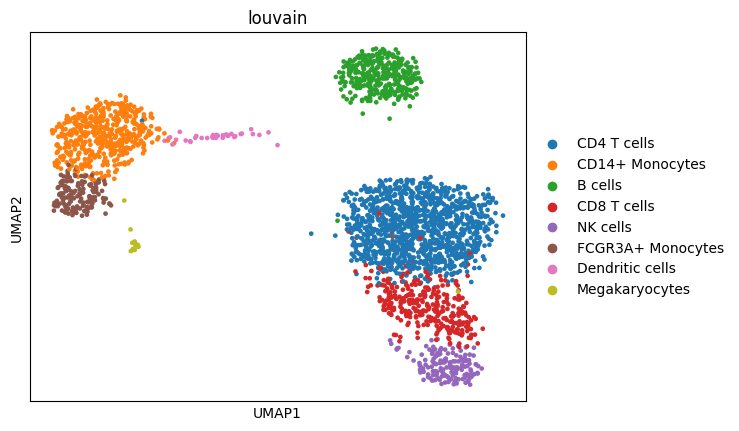

In [3]:
sc.pl.umap(adata, color="louvain")

Let me also introduce the 4 main parameters of MIDAA:
* The input data, it should be provided as a list of numpy arrays, one for each modality
* A normalization factor, this is especially useful when you work with raw counts. The normalization factors are modality specific and are applied before computing the likelihood. For instance if we call $\beta$ the output of the last layer of the decoder and the normalization factors as $\nu$ and our likelihood of choice is Poisson then the rate of the Poisson is gonna be computed as $exp(\beta) * \nu$.  
*  The likelihood used to compute the reconstruction loss of the data, we currently support: Gaussian (G), Poisson (P), Negative Binomial (NB), Categorical (C), Bernoulli (B), Beta (Beta). Again likelihoods are modality specific and are list of strings
*  The number of archetypes to fit

In [11]:
input_data = [adata.X] # as midaaa is designed for multiomics data you can still run on single modality but the input needs to be a list like [modality_1, modality_2, ...]
normalization_factor = [np.ones(adata.X.shape[0])]
likelihoods = ["G"]
narchetypes = 3

## Training Parameters

The two main parameters you can change are the number of steps and the learning rate. In our simulations we find that learning rates around 1e-3 and 1e-4 work well. Regarding the number of steps, they really depend on the problem but generally >500 is enough to get a decent model. We just want to highlight that for us a step menas a complete epoch, so the number of actual gradient iterations will be dependent on the batch size and number of samples.

In [12]:
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.001,
    steps = 600,
    narchetypes = narchetypes
    )

ELBO: 29763494.00000  : 100%|██████████| 600/600 [00:12<00:00, 47.32it/s]
/home/salvatore.milite/miniconda3/envs/scdeepaa/lib/python3.11/site-packages/pyro/primitives.py:137: RuntimeWarning: trying to observe a value outside of inference at loss
  warnings.warn(


We see how our model converges nicely and recapitulates the 3 main celltype groups we have (T-cells, B-cells and monocyte/dendritic)

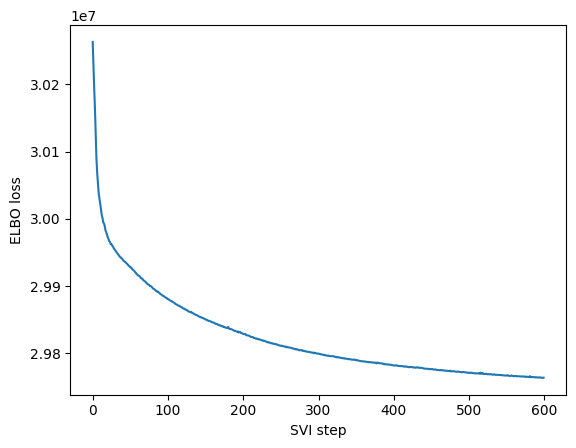

In [13]:
maa.plot_ELBO(res)

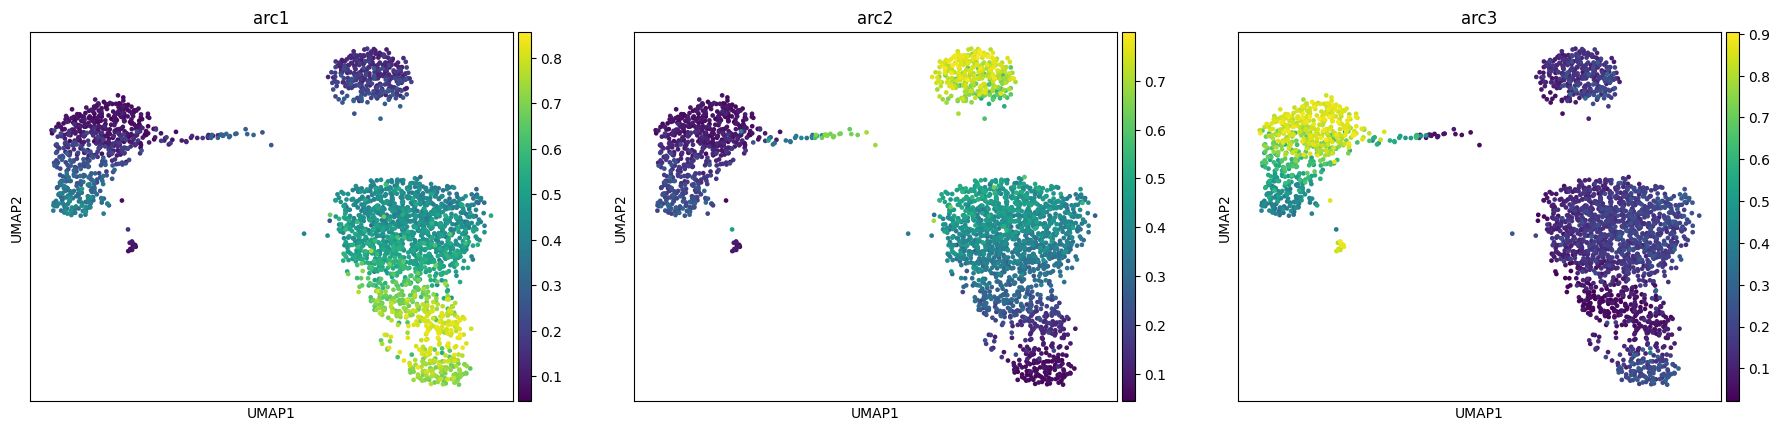

In [14]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

In [15]:
# A high learning rate generates instabilities and lead to bad fits
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.05,
    steps = 600,
    narchetypes = narchetypes
    )


ELBO: 29761718.00000  : 100%|██████████| 600/600 [00:12<00:00, 48.53it/s]


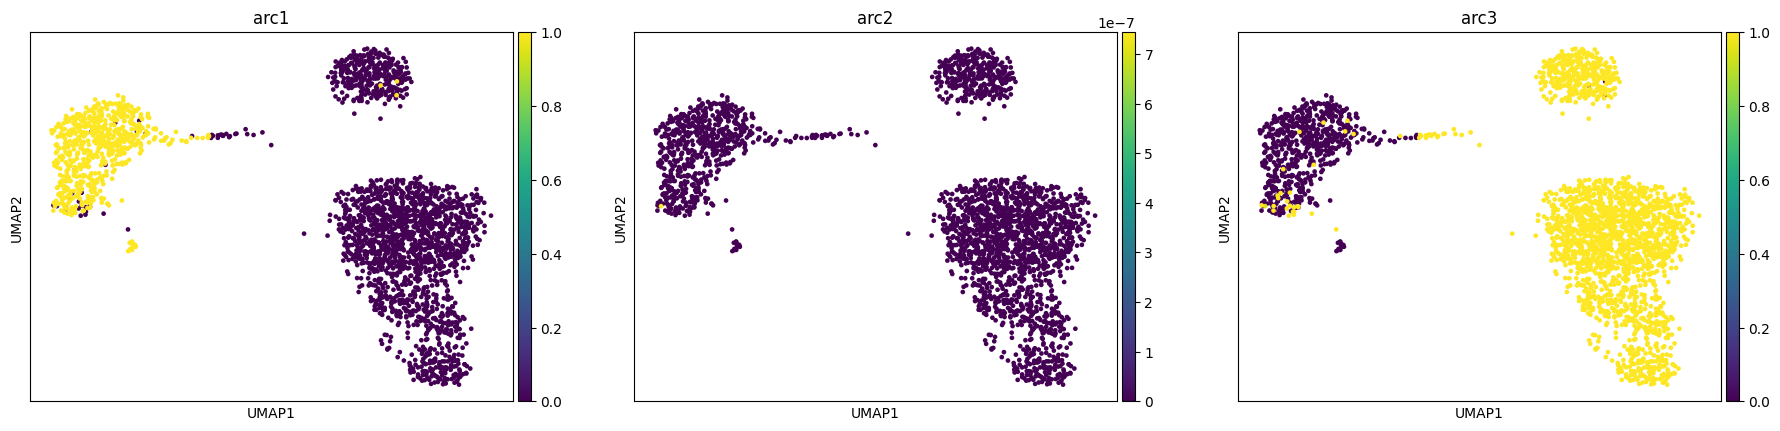

In [16]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

In [20]:
# A low learning rate does not converge
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 1e-6,
    steps = 600,
    narchetypes = narchetypes
    )

ELBO: 30254284.00000  : 100%|██████████| 600/600 [00:12<00:00, 48.09it/s]


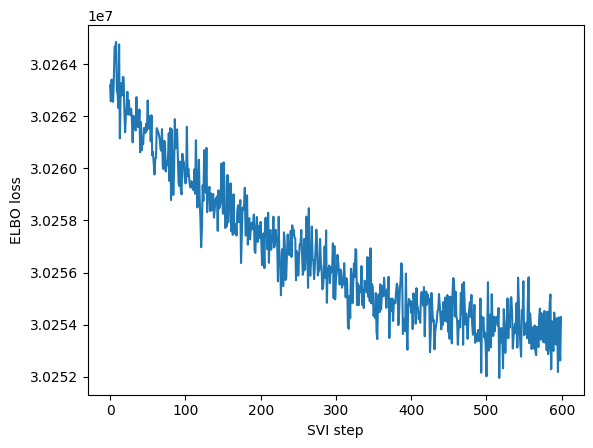

In [21]:
maa.plot_ELBO(res)

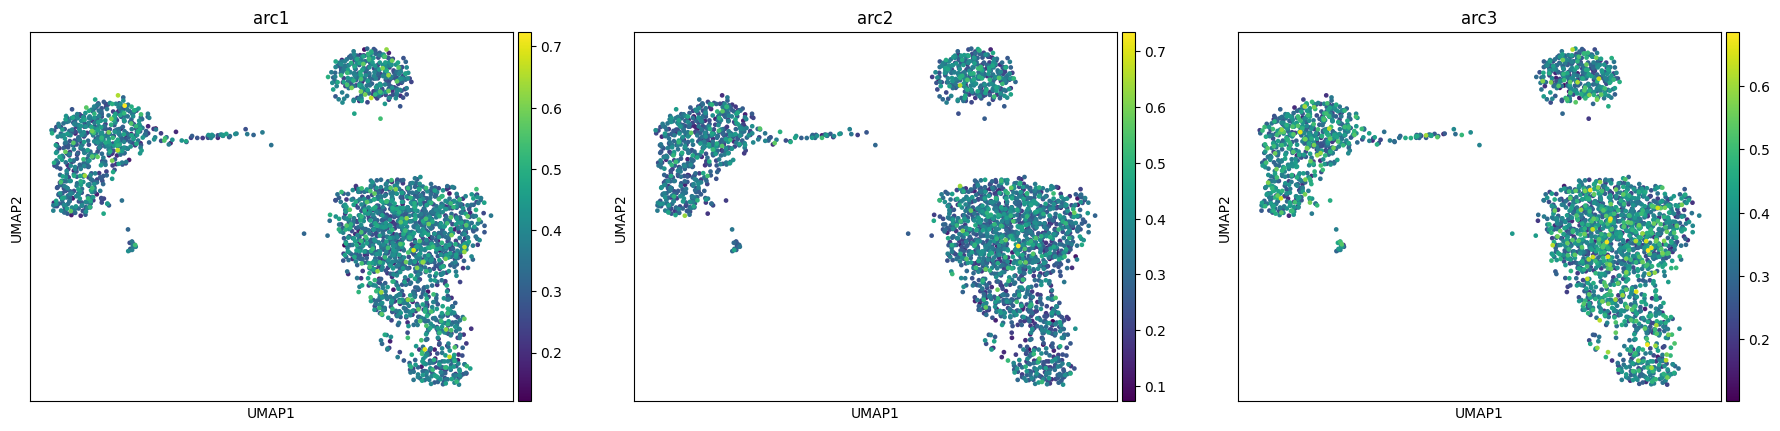

In [22]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

In [25]:
# Same for a low number of steps
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.001,
    steps = 10,
    narchetypes = narchetypes
    )

ELBO: 30122298.00000  : 100%|██████████| 10/10 [00:00<00:00, 45.33it/s]


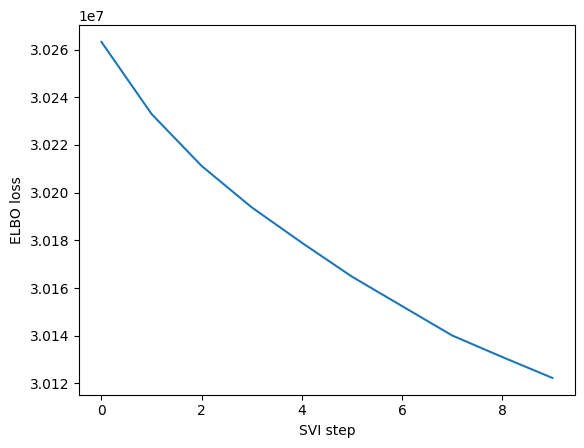

In [26]:
maa.plot_ELBO(res)

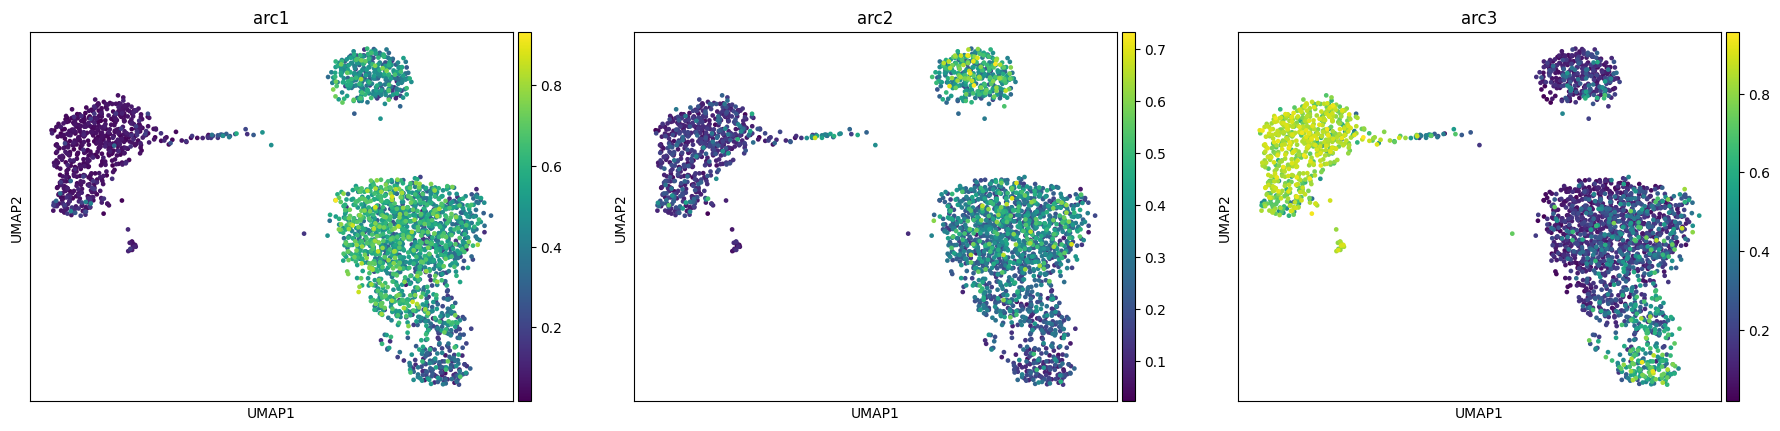

In [27]:
adata, arc_names = maa.add_to_obs_adata(res, adata)
sc.pl.umap(adata, color = arc_names)

In [ ]:
res = maa.fit_MIDAA(
    input_data,
    normalization_factor,
    likelihoods,
    lr = 0.001,
    steps = 600,
    narchetypes = narchetypes
    )

## Network parameters 

For now the model supports just convolution and linear networks (though we plan to make that part general and give some constructors for commonly used networks). You can modify the dimension of the encoder in the 3 different points:
* ``